In [1]:
import itertools
import logging
import pathlib
import time
import typing

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import polyflexmd.experiment_runner.config
import polyflexmd.data_analysis.pipelines.trajectory
import polyflexmd.data_analysis.data.read
import polyflexmd.data_analysis.data.constants
import polyflexmd.data_analysis.transform.transform as transform

import polyflexmd.data_analysis.theory.kremer_grest


In [3]:
df_trajectory = pd.read_csv(
    "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K/14-EEA1_short/b7015f55/data/processed/trajectories.csv",
    nrows=1000*64*100,
    dtype={
        **polyflexmd.data_analysis.data.constants.RAW_TRAJECTORY_DF_COLUMN_TYPES,
        "molecule-ID": np.ushort,
        "kappa": "category",
        "d_end": "category",
    }
)
df_trajectory

,t,id,type,x,y,z,molecule-ID,kappa
0,35000000,1,1,0.000000,0.000000,0.000000,1,190.2
1,35000000,2,1,-0.336178,0.186169,0.890632,1,190.2
2,35000000,3,2,-0.629315,0.477521,1.744390,1,190.2
3,35000000,4,2,-0.889052,0.792841,2.670470,1,190.2
4,35000000,5,2,-1.091350,1.165560,3.501400,1,190.2
...,...,...,...,...,...,...,...,...
6399995,35009900,63996,2,-13.045400,-48.827301,-18.388901,1000,190.2
6399996,35009900,63997,2,-13.611400,-49.617298,-18.648500,1000,190.2
6399997,35009900,63998,2,-14.195900,-50.367001,-18.894800,1000,190.2
6399998,35009900,63999,2,-14.749500,-51.118099,-19.167101,1000,190.2


In [2]:
df_trajectory["t"].unique()

NameError: name 'df_trajectory' is not defined

In [5]:
pandarallel.initialize(
    nb_workers=32,
    progress_bar=False,
    use_memory_fs=None
)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
l_K_estimate = transform.estimate_kuhn_length_df(
        df_trajectory=df_trajectory,
        group_by_params=["kappa"],
        N_beads=64,
        l_b=.97
)
l_K_estimate

l_K     d_l_K
kappa t                             
190.2 35000000  368.952645  0.366124
      35000100  367.874982  0.355846
      35000200  367.387865  0.364598
      35000300  367.023664  0.375784
      35000400  366.419653  0.401701
...                    ...       ...
      35009500  369.878265  0.573691
      35009600  369.788314  0.553128
      35009700  369.620978  0.547123
      35009800  369.285063  0.530754
      35009900  368.941326  0.544197

[100 rows x 2 columns]

In [11]:
df_trajectories.memory_usage().sum() / 10e6

166.4000136

In [13]:
l_K_estimate = transform.estimate_kuhn_length_df(
    df_trajectory=df_trajectories,
    group_by_params=["kappa"],
    N_beads=64,
    l_b=.97,
    n_processes=64
)
l_K_estimate

,l_K,d_l_K
kappa,,
190.2,369.493715,0.298375


In [2]:
angle_matrix_avg = np.load("/home/egor/Projects/polyflexmd/data/angle_matrix.npy")
angle_matrix_avg

array([[0.8914122 , 0.70492554, 0.70492524, ..., 0.70492506, 0.70492506,
        0.70492506],
       [0.70492554, 0.8748946 , 0.7049259 , ..., 0.70492506, 0.7049251 ,
        0.70492506],
       [0.70492524, 0.7049259 , 0.87539536, ..., 0.70492506, 0.70492506,
        0.70492506],
       ...,
       [0.70492506, 0.70492506, 0.70492506, ..., 0.8734005 , 0.70492554,
        0.70492536],
       [0.70492506, 0.7049251 , 0.70492506, ..., 0.70492554, 0.87361544,
        0.70492536],
       [0.70492506, 0.70492506, 0.70492506, ..., 0.70492536, 0.70492536,
        0.8736339 ]], dtype=float32)

<Axes: >

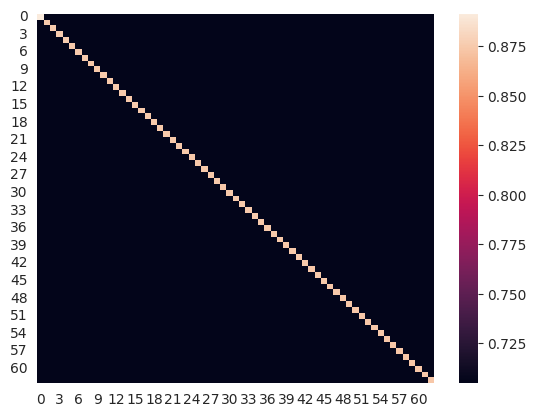

In [21]:
sns.heatmap(angle_matrix_avg)

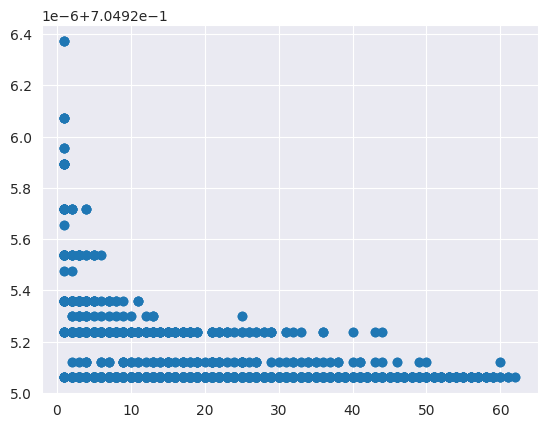

In [20]:
idx_up = np.triu_indices(angle_matrix_avg.shape[0], k=1)
idx_down = np.tril_indices(angle_matrix_avg.shape[0], k=-1)
idx = np.hstack([idx_up, idx_down])

x_1d = abs(idx[0] - idx[1])

plt.scatter(x_1d, angle_matrix_avg[idx[0], idx[1]])

In [22]:
angle_matrix_avg[idx_up]

array([0.70492554, 0.70492524, 0.70492506, ..., 0.70492554, 0.70492536,
       0.70492536], dtype=float32)

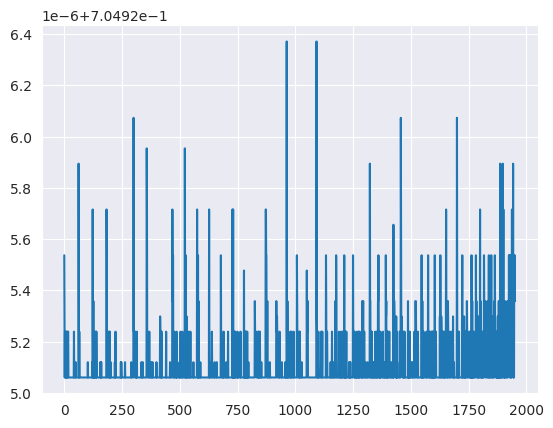

In [23]:
plt.plot(angle_matrix_avg[idx_up])

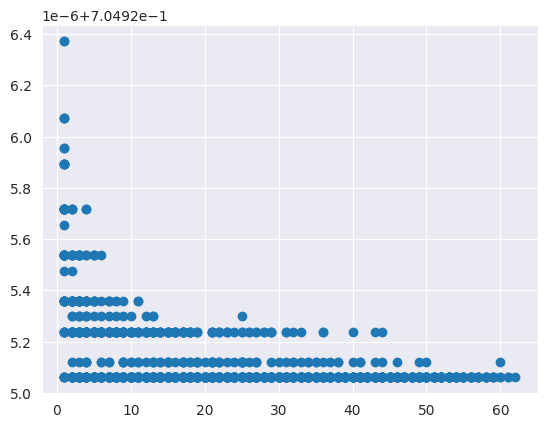

In [25]:
plt.scatter(abs(idx_up[0] - idx_up[1]), angle_matrix_avg[idx_up])

In [30]:
np.unique(abs(idx_up[0] - idx_up[1]))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

In [29]:
x_data_uniq = np.arange(0, angle_matrix_avg.shape[0], 1)
x_data_uniq

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

In [35]:
y_data_uniq = angle_matrix_avg[0, :]
y_data_uniq

array([0.8914122 , 0.70492554, 0.70492524, 0.70492506, 0.70492524,
       0.70492524, 0.70492506, 0.70492524, 0.70492506, 0.70492506,
       0.70492506, 0.70492524, 0.70492506, 0.70492506, 0.70492524,
       0.70492506, 0.70492506, 0.70492524, 0.70492524, 0.70492506,
       0.70492506, 0.70492506, 0.70492506, 0.70492506, 0.70492506,
       0.70492506, 0.70492506, 0.70492506, 0.70492506, 0.70492506,
       0.70492506, 0.70492506, 0.70492506, 0.70492506, 0.70492506,
       0.70492506, 0.70492506, 0.70492506, 0.70492506, 0.70492506,
       0.70492506, 0.70492506, 0.70492506, 0.70492524, 0.70492506,
       0.70492506, 0.70492506, 0.70492506, 0.70492506, 0.70492506,
       0.7049251 , 0.70492506, 0.70492506, 0.70492506, 0.70492506,
       0.70492506, 0.70492506, 0.70492506, 0.70492506, 0.70492506,
       0.70492506, 0.70492506, 0.70492506], dtype=float32)

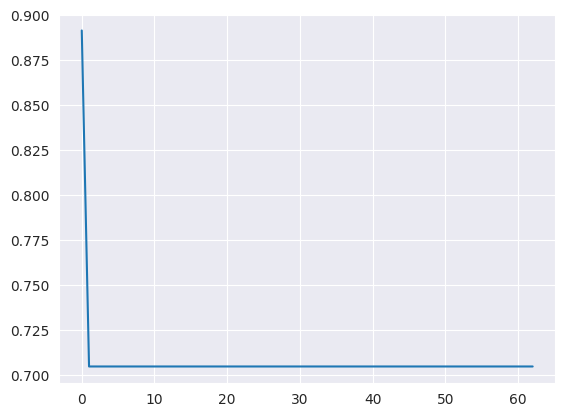

In [36]:
plt.plot(x_data_uniq, y_data_uniq)

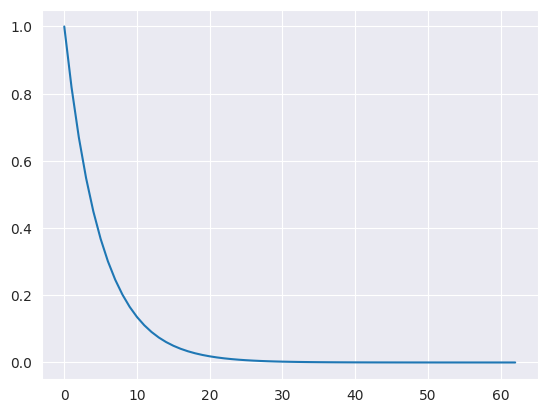

In [58]:
def f(x, l_p):
    return np.exp(-np.abs(x)/l_p)

plt.plot(x_data_uniq, f(x_data_uniq, 5))

In [38]:
np.unique(angle_matrix_avg[idx_up])

array([0.70492506, 0.7049251 , 0.70492524, 0.7049253 , 0.70492536,
       0.7049255 , 0.70492554, 0.70492566, 0.7049257 , 0.7049259 ,
       0.70492595, 0.7049261 , 0.7049264 ], dtype=float32)

In [41]:
cos_theta_avg = np.mean(angle_matrix_avg)
l_b = .97
l_b * (1 + cos_theta_avg) / (1 - cos_theta_avg)


5.665174273271874

In [66]:
angle_matrix_12 = np.load("/home/egor/Projects/polyflexmd/data/angle_matrix_12.npy")
angle_matrix_12

array([[1.        , 0.9948643 , 0.98966163, ..., 0.7431637 , 0.7393933 ,
        0.73542476],
       [0.9948643 , 1.        , 0.9948885 , ..., 0.7462538 , 0.74250007,
        0.73854005],
       [0.98966163, 0.9948885 , 1.        , ..., 0.74953115, 0.74575216,
        0.74180037],
       ...,
       [0.7431637 , 0.7462538 , 0.74953115, ..., 1.        , 0.9948451 ,
        0.9895419 ],
       [0.7393933 , 0.74250007, 0.74575216, ..., 0.9948451 , 1.        ,
        0.9948256 ],
       [0.73542476, 0.73854005, 0.74180037, ..., 0.9895419 , 0.9948256 ,
        1.        ]], dtype=float32)

<Axes: >

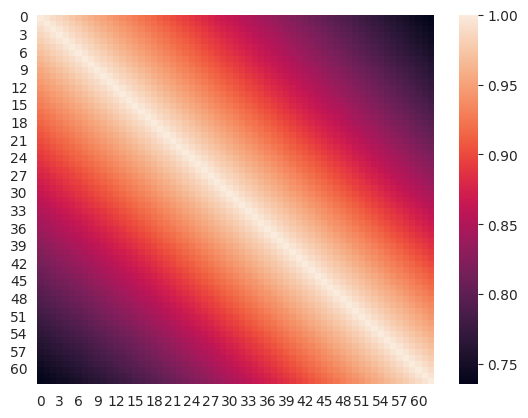

In [67]:
sns.heatmap(angle_matrix_12)

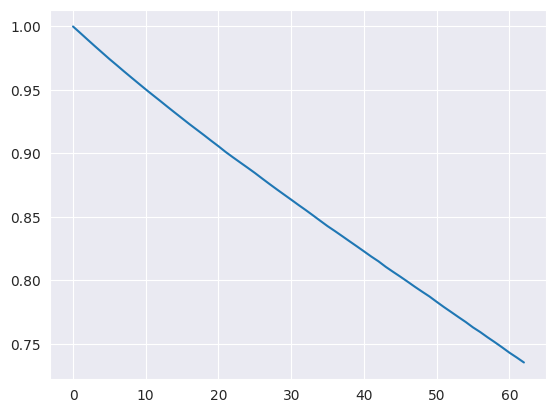

In [56]:
plt.plot(x_data_uniq, angle_matrix_12[0, :])



In [52]:
import scipy.optimize
scipy.optimize.curve_fit(f, x_data_uniq, angle_matrix_12[0, :])

(array([203.78589875]), array([[0.03785497]]))

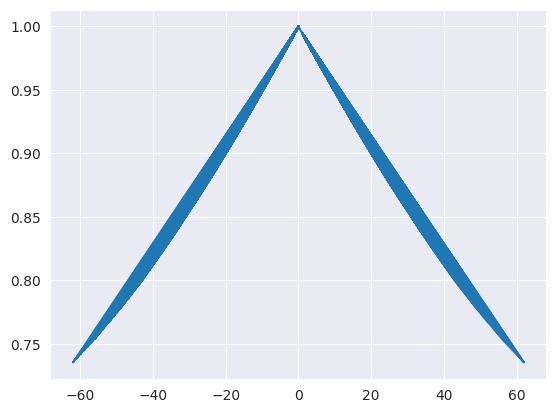

In [62]:
idx_up = np.triu_indices(angle_matrix_avg.shape[0])
idx_down = np.tril_indices(angle_matrix_avg.shape[0], k=-1)
idx = np.hstack((idx_down, idx_up))

x_data = idx[0]-idx[1]
y_data = angle_matrix_12[idx[0], idx[1]]
plt.plot(x_data, y_data)

In [63]:
scipy.optimize.curve_fit(f, x_data, y_data)

(array([197.3055135]), array([[0.00489472]]))

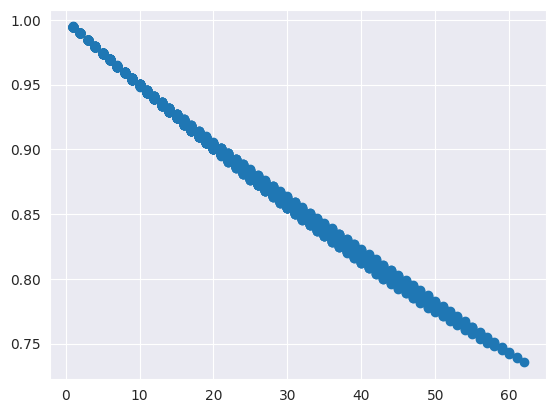

In [57]:
plt.scatter(abs(idx_up[0] - idx_up[1]), angle_matrix_12[idx_up])

In [60]:
scipy.optimize.curve_fit(f, abs(idx_up[0] - idx_up[1]), angle_matrix_12[idx_up])

(array([197.30551352]), array([[0.00994992]]))